<a href="https://colab.research.google.com/github/OVP2023/time_series/blob/main/dz5_SSA_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
    При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
    Посмотрите на результаты с разными длинами окон.
    Обязательно визуализируйте результаты аналогично материалу с занятия.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [18]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
mean_monthly_temp = pd.read_csv("/content/drive/MyDrive/Datasets/VR/mean-monthly-air-temperature-deg.csv")
airlines_passengers = pd.read_csv("/content/drive/MyDrive/Datasets/VR/international-airline-passengers.csv")

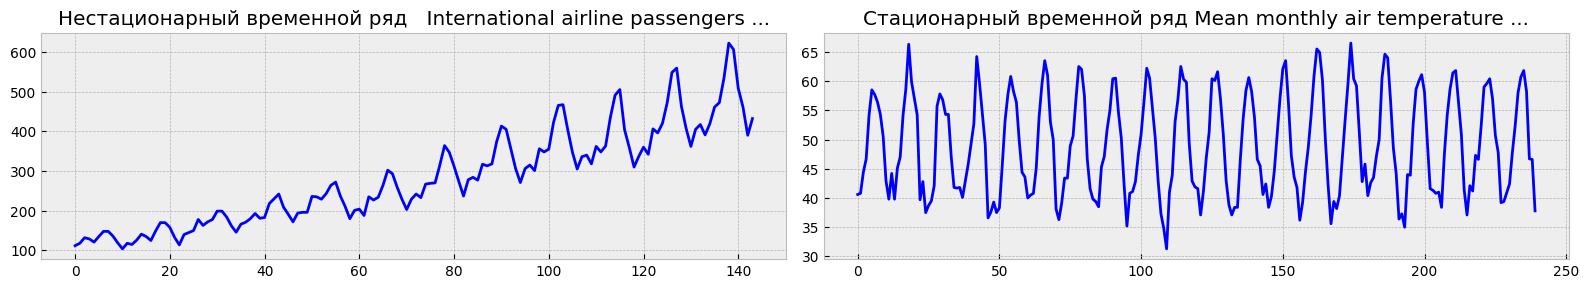

In [5]:
all_series = {
    "Нестационарный временной ряд   International airline passengers ...": airlines_passengers["Count"],
    "Стационарный временной ряд Mean monthly air temperature ...": mean_monthly_temp["Deg"]
}

with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [40]:
len(airlines_passengers) #Длина временного ряда

144

In [42]:
# 1.Создаем матрицу траекторий
N=144
L = 32 # Длина окна
K = N - L + 1 # Количество столбцов в матрице траекторий
# Создаем матрицу траекторий (Ганкеля)
X = np.column_stack([airlines_passengers['Count'] [i:i+L] for i in range(0,K)])
X

array([[112, 118, 132, ..., 362, 348, 363],
       [118, 132, 129, ..., 348, 363, 435],
       [132, 129, 121, ..., 363, 435, 491],
       ...,
       [178, 199, 199, ..., 606, 508, 461],
       [199, 199, 184, ..., 508, 461, 390],
       [199, 184, 162, ..., 461, 390, 432]])

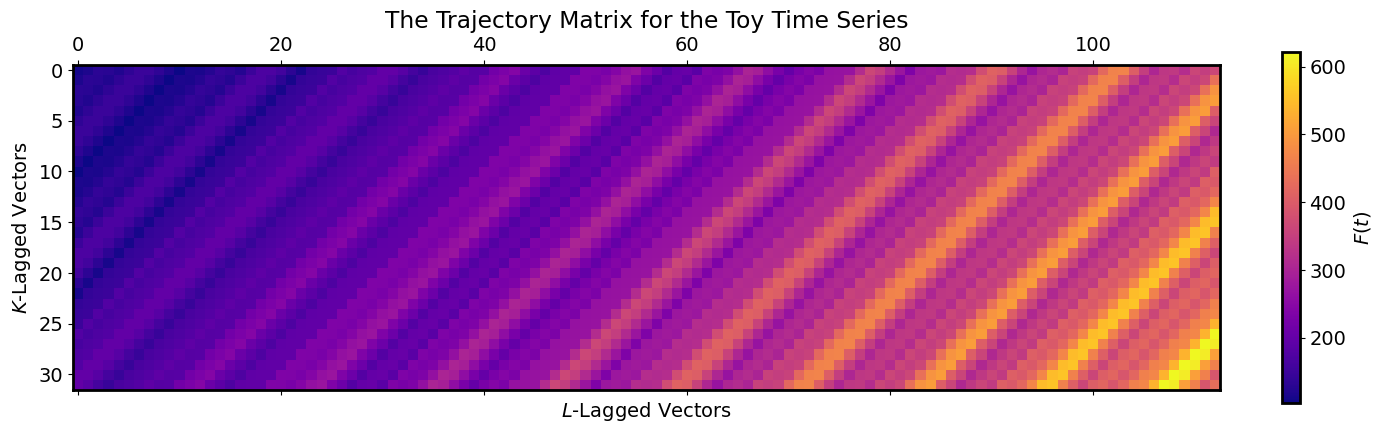

In [31]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for the Toy Time Series");

In [36]:
# 2.Разложение матрицы траекторий на сингулярные вектора и значения
d = np.linalg.matrix_rank(X)
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

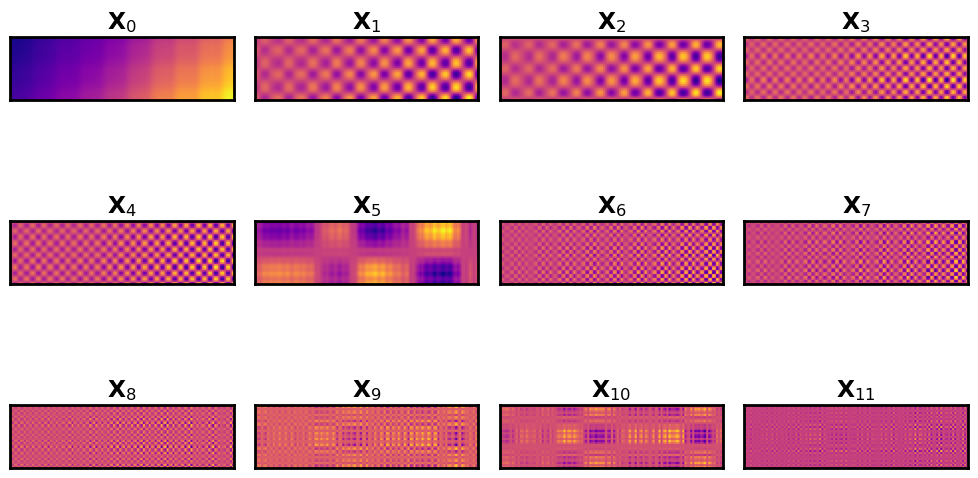

In [39]:
# 3.Выделение элементов цикла и тенденции из сингулярных векторов из матрицы траектории
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

n = min(12, d)  #In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

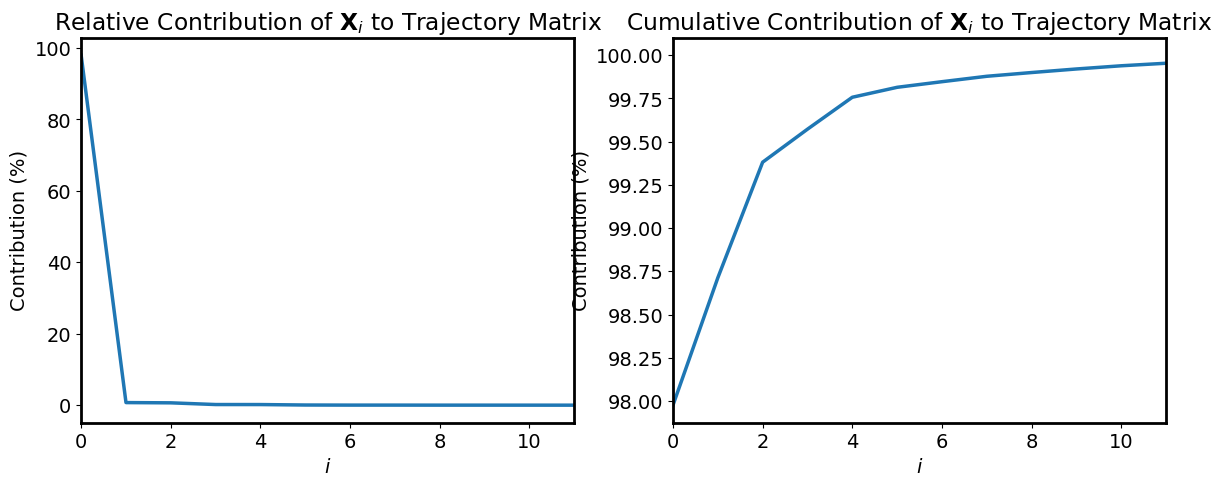

In [43]:
#4.Реконструкции временных рядов (восстановления тренда и сезонностей, удаление шума)
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

На приведенных выше графиках изображены относительные и кумулятивные вклады первых 12 Xi в разложение X=∑d−1i=0Xi. Элементарная матрицы X0 вносит 98% в разложение X. Вместе первые пять элементарных матриц составляют 99,75%. Элементарные матрицы, которые вносят равный вклад в разложение (то есть σi≈σi+1), вероятно, будут сгруппированы вместе при реконструкции временного ряда, например X1 и X2 должны быть сгруппированы вместе.

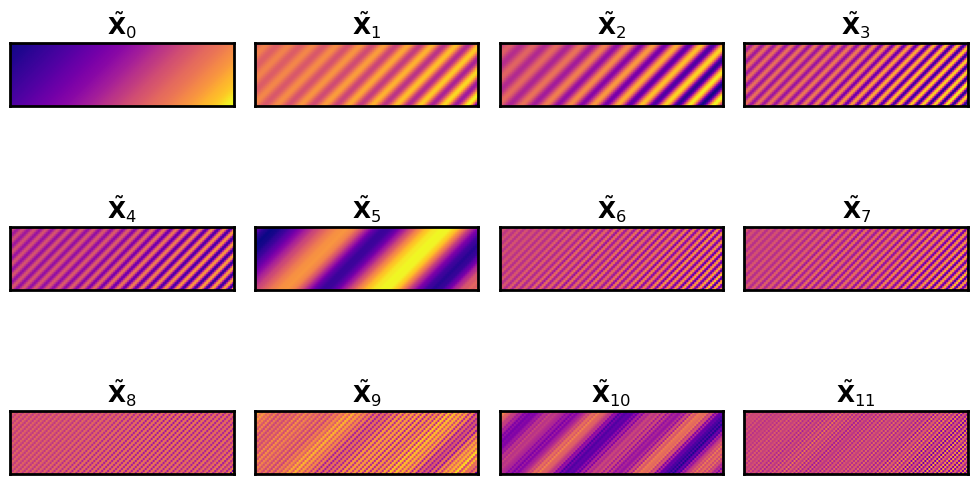

In [44]:
def Hankelise(X):  #функция формирования матрицы Ганкеля из элементарной матрицы
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning.
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

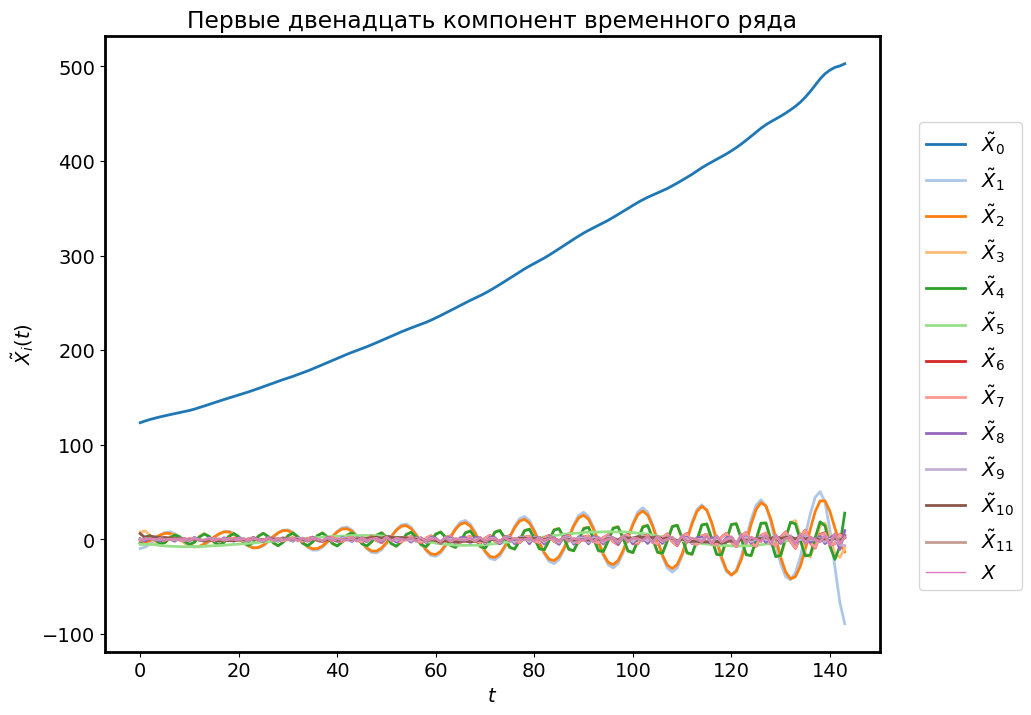

In [53]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


n = min(12,d) # In case of noiseless time series with d < 12.
t = np.arange(0,N)
# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    X_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, X_i, lw=2)

fig.axes.plot(t, X_i, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{X}_i(t)$")
legend = [r"$\tilde{X}_{%s}$" %i for i in range(n)] + ["$X$"]
fig.set_title("Первые двенадцать компонент временного ряда")
fig.legend(legend, loc=(1.05,0.1));